# Impor Packages

In [1]:
import os
import torch
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Lambda
import random
import torchvision.transforms as T
import torchvision.transforms as transforms

# (A) : Loading Data

In [2]:
df_train = pd.read_csv('./Data/HW2_data/Q3_train.csv')
df_test = pd.read_csv('./Data/HW2_data/Q3_test.csv')
df_train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


# (A) : Convert Dataframe To Numpy Array

In [3]:
train_percent = 0.8

df_train_np = df_train.to_numpy()
df_test_np = df_test.to_numpy()

x_train = df_train_np[:int(len(df_train_np) * train_percent),1:]
y_train = df_train_np[:int(len(df_train_np) * train_percent),:1]


x_val = df_train_np[int(len(df_train_np) * train_percent):,1:]
y_val = df_train_np[int(len(df_train_np) * train_percent):,:1]

x_test = df_test_np[:,1:]
y_test = df_test_np[:,:1]

print("Train: ", x_train.shape ,y_train.shape)
print("Validation: ", x_val.shape ,y_val.shape)
print("Test: " ,x_test.shape ,y_test.shape)

Train:  (21964, 784) (21964, 1)
Validation:  (5491, 784) (5491, 1)
Test:  (7172, 784) (7172, 1)


# (A) : Showing Some Samples From Dataset

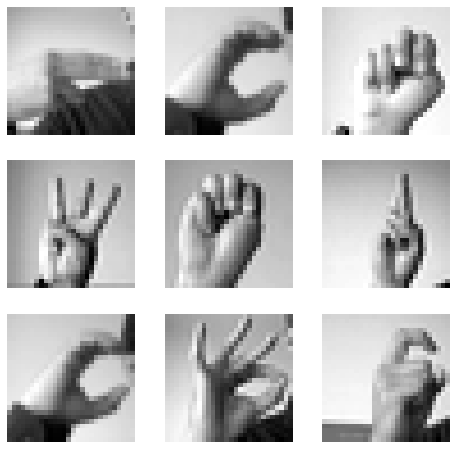

In [49]:
figure = plt.figure(figsize=(8, 8))
rows_id = random.sample(range(0, x_train.shape[0]-1), 9)
j = 1
for i in rows_id:
    figure.add_subplot(3, 3, j)
    plt.axis("off")
    plt.imshow(x_train[i,:].reshape((28,28)), cmap="gray")
    j+=1

# (B) : Create Custom Dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, X, Y, transform=None, target_transform=None):
        
        self.label = Y
        self.feature = X
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        
        feature = self.feature[idx]/255.
        label = self.label[idx]
        
#         if self.transform:
#             feature = self.transform(feature)
            
#         if self.target_transform:
#             labels = self.target_transform(label)
            
        return feature, label

# (B) : Making Dataset Iterable

In [6]:
batch_size = 128

train_data = CustomDataset(x_train, y_train)
test_data = CustomDataset(x_test, y_test)
val_data = CustomDataset(x_val, y_val)


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# (B) : Create Model Class

In [7]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 25)
        )

    def forward(self, x):
        logits = self.mlp(x)
        return logits

# (B) : Define Train & Test & Validation Loop

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        
        pred = model(X.to(torch.float32).to(device))
        loss = loss_fn(pred, y.to(device).squeeze(1))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (pred.argmax(1) == y.to(device).squeeze(1)).type(torch.float).sum().item()
            
    train_loss /= num_batches
    train_acc /= size
    
    log['train_loss'].append(train_loss)
    log['train_acc'].append(train_acc)
    
    print(f"Train Result: \n Accuracy: {(100*train_acc):>0.1f}%, Avg Train loss: {train_loss:>8f} \n")


def valid_loop(dataloader, model, loss_fn, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, valid_acc = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(torch.float32).to(device))
            loss = loss_fn(pred, y.to(device).squeeze(1))
            
            valid_loss += loss.item()
            valid_acc += (pred.argmax(1) == y.to(device).squeeze(1)).type(torch.float).sum().item()

    valid_loss /= num_batches
    valid_acc /= size
    
    log['valid_loss'].append(valid_loss)
    log['valid_acc'].append(valid_acc)
    print(f"Validation Result: \n Accuracy: {(100*valid_acc):>0.1f}%, Avg Validation loss: {valid_loss:>8f} \n")

    
    
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(torch.float32).to(device))
            loss = loss_fn(pred, y.to(device).squeeze(1))
            
            test_loss += loss.item()
            test_acc += (pred.argmax(1) == y.to(device).squeeze(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc /= size 
    print(f"Test Result: \n Accuracy: {(100*test_acc):>0.1f}%, Avg Test loss: {test_loss:>8f} \n")

# (B) : Instatiate Model Class Base On SGD

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_sgd = MyNet().to(device)

criterion = nn.CrossEntropyLoss()

lr_sgd = 0.01
epochs = 30
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=lr_sgd, momentum=0.9)

# (B) : Training Process Based On SGD

In [24]:
log = {'train_loss':[], 'valid_loss' : [], 'train_acc' : [], 'valid_acc' : []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_sgd.train()
    train_loop(train_loader, model_sgd, criterion, optimizer_sgd, log)
    model_sgd.eval()
    valid_loop(val_loader, model_sgd, criterion, log)
print("Done!")

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 7.7%, Avg Train loss: 3.150784 

Validation Result: 
 Accuracy: 11.4%, Avg Validation loss: 2.988561 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 22.4%, Avg Train loss: 2.474191 

Validation Result: 
 Accuracy: 34.8%, Avg Validation loss: 1.969199 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 41.1%, Avg Train loss: 1.764752 

Validation Result: 
 Accuracy: 51.6%, Avg Validation loss: 1.429043 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 54.5%, Avg Train loss: 1.346487 

Validation Result: 
 Accuracy: 60.5%, Avg Validation loss: 1.136069 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 64.8%, Avg Train loss: 1.038577 

Validation Result: 
 Accuracy: 65.6%, Avg Validation loss: 0.982940 

Epoch 6
-------------------------------
Train Result: 
 Accuracy: 72.1%, Avg Train loss: 0.830877 

Validation Result: 
 Accuracy: 74.6%, Avg Validatio

# (B) : Plot The Result On SGD

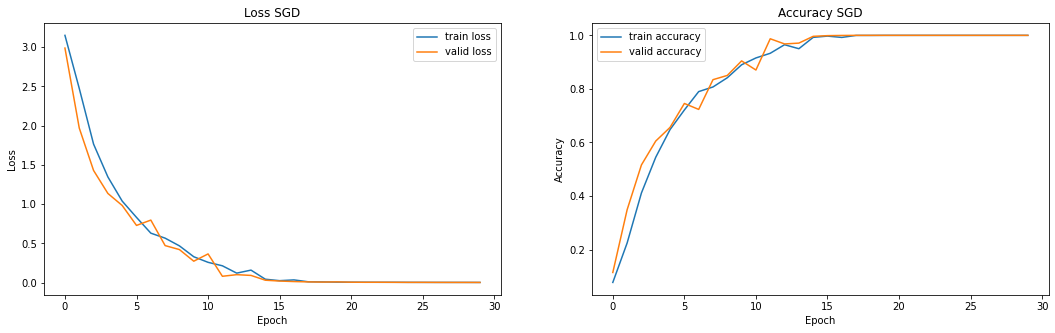

In [25]:
n_epochs = [*range(epochs)]
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(n_epochs, log['train_loss'])
plt.plot(n_epochs, log['valid_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss SGD')
plt.legend(['train loss', 'valid loss'])
plt.subplot(122)
plt.plot(n_epochs, log['train_acc'])
plt.plot(n_epochs, log['valid_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy SGD')
plt.legend(['train accuracy', 'valid accuracy'])

# (B) : Instatiate Model Class Base On Adam

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_adam = MyNet().to(device)

criterion = nn.CrossEntropyLoss()

lr_adam = 3e-4
epochs = 30
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=lr_adam)

# (B) : Training Process Based On Adam

In [19]:
log = {'train_loss':[], 'valid_loss' : [], 'train_acc' : [], 'valid_acc' : []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_adam.train()
    train_loop(train_loader, model_adam, criterion, optimizer_adam, log)
    model_adam.eval()
    valid_loop(val_loader, model_adam, criterion, log)
print("Done!")

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 23.0%, Avg Train loss: 2.483481 

Validation Result: 
 Accuracy: 39.0%, Avg Validation loss: 1.819858 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 48.0%, Avg Train loss: 1.590184 

Validation Result: 
 Accuracy: 51.8%, Avg Validation loss: 1.418707 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 58.9%, Avg Train loss: 1.237977 

Validation Result: 
 Accuracy: 64.8%, Avg Validation loss: 1.060985 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 67.3%, Avg Train loss: 0.982316 

Validation Result: 
 Accuracy: 71.2%, Avg Validation loss: 0.870310 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 74.9%, Avg Train loss: 0.757903 

Validation Result: 
 Accuracy: 78.5%, Avg Validation loss: 0.652546 

Epoch 6
-------------------------------
Train Result: 
 Accuracy: 81.4%, Avg Train loss: 0.580777 

Validation Result: 
 Accuracy: 84.9%, Avg Validati

# (B) : Plot The Result On Adam

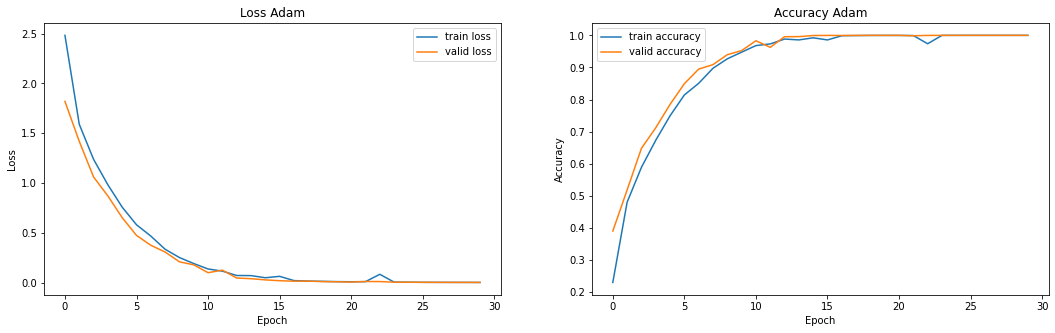

In [21]:
n_epochs = [*range(epochs)]
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(n_epochs, log['train_loss'])
plt.plot(n_epochs, log['valid_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss Adam')
plt.legend(['train loss', 'valid loss'])
plt.subplot(122)
plt.plot(n_epochs, log['train_acc'])
plt.plot(n_epochs, log['valid_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy Adam')
plt.legend(['train accuracy', 'valid accuracy'])

# (B) : Compare SGD & Adam On Test Data
 Point : Using Adam make better result on test data

In [26]:
print('Model result on Adam optimizer:')
model_adam.eval()
test_loop(test_loader, model_adam, criterion)
print('Model result on SGD optimizer:')
model_sgd.eval()
test_loop(test_loader, model_sgd, criterion)

Model result on Adam optimizer:
Test Result: 
 Accuracy: 78.2%, Avg Test loss: 1.463932 

Model result on SGD optimizer:
Test Result: 
 Accuracy: 77.6%, Avg Test loss: 1.332979 



# (C) : Create Model Class With Dropout

In [28]:
class DropoutNet(nn.Module):
    def __init__(self):
        super(DropoutNet, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 25)
        )

    def forward(self, x):
        logits = self.mlp(x)
        return logits

# (C) : Instatiate Dropout Model Class Base On SGD (Dropout)

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_sgd_drop = DropoutNet().to(device)

criterion = nn.CrossEntropyLoss()

lr_sgd = 0.01
epochs = 40
optimizer_sgd_drop = torch.optim.SGD(model_sgd_drop.parameters(), lr=lr_sgd, momentum=0.9)

# (C) : Training Process Based On SGD (Dropout Model)

In [30]:
log = {'train_loss':[], 'valid_loss' : [], 'train_acc' : [], 'valid_acc' : []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_sgd_drop.train()
    train_loop(train_loader, model_sgd_drop, criterion, optimizer_sgd_drop, log)
    model_sgd_drop.eval()
    valid_loop(val_loader, model_sgd_drop, criterion, log)
print("Done!")

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 6.6%, Avg Train loss: 3.160531 

Validation Result: 
 Accuracy: 12.5%, Avg Validation loss: 3.049669 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 20.7%, Avg Train loss: 2.523773 

Validation Result: 
 Accuracy: 33.3%, Avg Validation loss: 2.022345 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 39.5%, Avg Train loss: 1.817978 

Validation Result: 
 Accuracy: 50.4%, Avg Validation loss: 1.512326 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 53.4%, Avg Train loss: 1.381731 

Validation Result: 
 Accuracy: 58.6%, Avg Validation loss: 1.228282 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 62.2%, Avg Train loss: 1.109588 

Validation Result: 
 Accuracy: 69.7%, Avg Validation loss: 0.896853 

Epoch 6
-------------------------------
Train Result: 
 Accuracy: 66.8%, Avg Train loss: 0.961133 

Validation Result: 
 Accuracy: 77.2%, Avg Validatio

In [31]:
print('Dropout model result on SGD optimizer:')
model_sgd_drop.eval()
test_loop(test_loader, model_sgd_drop, criterion)

Dropout model result on SGD optimizer:
Test Result: 
 Accuracy: 78.4%, Avg Test loss: 1.351311 



# (C) : Plot The Result On SGD (Dropout Model)

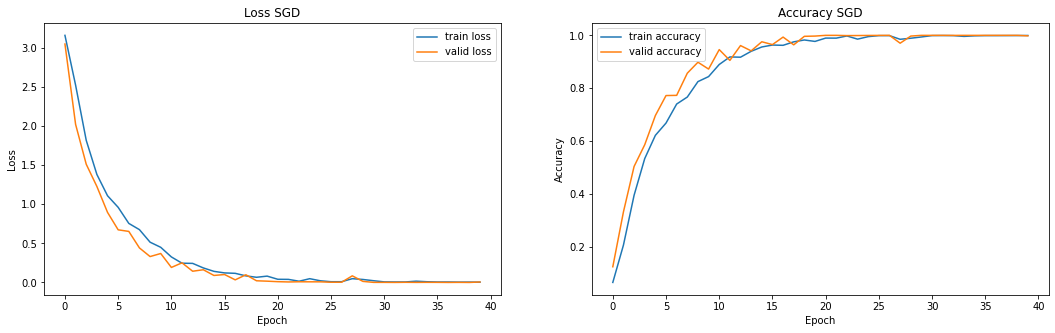

In [32]:
n_epochs = [*range(epochs)]
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(n_epochs, log['train_loss'])
plt.plot(n_epochs, log['valid_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss SGD')
plt.legend(['train loss', 'valid loss'])
plt.subplot(122)
plt.plot(n_epochs, log['train_acc'])
plt.plot(n_epochs, log['valid_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy SGD')
plt.legend(['train accuracy', 'valid accuracy'])

# (C) : Instatiate Model Class Base On Adam (Dropout Model)

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_adam_drop = DropoutNet().to(device)

criterion = nn.CrossEntropyLoss()

lr_adam = 3e-4
epochs = 40
optimizer_adam_drop = torch.optim.Adam(model_adam_drop.parameters(), lr=lr_adam)

# (C) : Training Process Based On Adam (Dropout Model)

In [34]:
log = {'train_loss':[], 'valid_loss' : [], 'train_acc' : [], 'valid_acc' : []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_adam_drop.train()
    train_loop(train_loader, model_adam_drop, criterion, optimizer_adam_drop, log)
    model_adam_drop.eval()
    valid_loop(val_loader, model_adam_drop, criterion, log)
print("Done!")

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 20.2%, Avg Train loss: 2.572759 

Validation Result: 
 Accuracy: 41.4%, Avg Validation loss: 1.826330 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 47.2%, Avg Train loss: 1.597981 

Validation Result: 
 Accuracy: 61.2%, Avg Validation loss: 1.226167 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 60.2%, Avg Train loss: 1.166535 

Validation Result: 
 Accuracy: 70.7%, Avg Validation loss: 0.920558 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 69.7%, Avg Train loss: 0.894868 

Validation Result: 
 Accuracy: 80.3%, Avg Validation loss: 0.646426 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 77.1%, Avg Train loss: 0.682383 

Validation Result: 
 Accuracy: 84.9%, Avg Validation loss: 0.497202 

Epoch 6
-------------------------------
Train Result: 
 Accuracy: 82.9%, Avg Train loss: 0.514279 

Validation Result: 
 Accuracy: 88.2%, Avg Validati

# (C) : Plot The Result On Adam (Dropout Model)

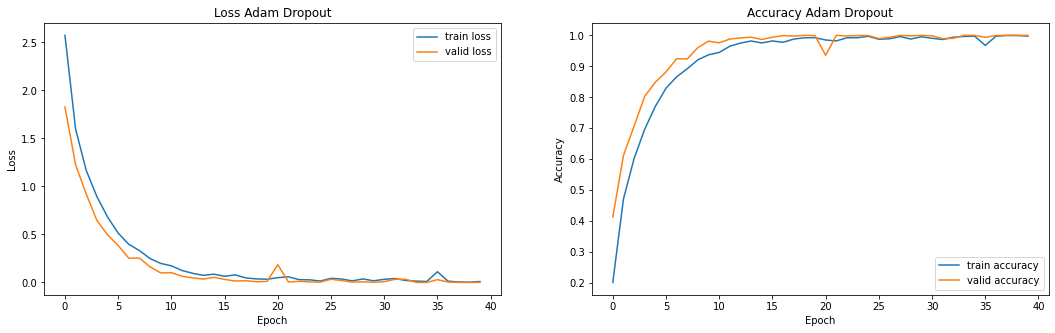

In [35]:
n_epochs = [*range(epochs)]
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(n_epochs, log['train_loss'])
plt.plot(n_epochs, log['valid_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss Adam Dropout')
plt.legend(['train loss', 'valid loss'])
plt.subplot(122)
plt.plot(n_epochs, log['train_acc'])
plt.plot(n_epochs, log['valid_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy Adam Dropout')
plt.legend(['train accuracy', 'valid accuracy'])

# (C) : Compare SGD & Adam On Test Data (Dropout Model)

In [36]:
print('Dropout model result on Adam optimizer:')
model_adam_drop.eval()
test_loop(test_loader, model_adam_drop, criterion)
print('Dropout model result on SGD optimizer:')
model_sgd_drop.eval()
test_loop(test_loader, model_sgd_drop, criterion)

Dropout model result on Adam optimizer:
Test Result: 
 Accuracy: 81.6%, Avg Test loss: 0.999835 

Dropout model result on SGD optimizer:
Test Result: 
 Accuracy: 78.4%, Avg Test loss: 1.392899 



# (D) : All Trained Model Specification And Result (Dropout Model)
 Point1 : Using dropout decrease test error because it helps to generalization.
 
 Point2 : Using dropout has better result on Adam Optimizer and better generalize 
 
 Point3 : Adding Dropout to Adam increased accuracy to 82%

In [37]:
print('Model With 3 layer Mlp on Adam optimizer:')
model_adam.eval()
test_loop(test_loader, model_adam, criterion)
print('Model With 3 layer Mlp on Adam optimizer:')
model_sgd.eval()
test_loop(test_loader, model_sgd, criterion)
print('Model With 3 layer Mlp and One layer Dropout (P = 0.5) on Adam optimizer:')
model_adam_drop.eval()
test_loop(test_loader, model_adam_drop, criterion)
print('Model With 3 layer Mlp and One layer Dropout (P = 0.5) on SGD optimizer:')
model_sgd_drop.eval()
test_loop(test_loader, model_sgd_drop, criterion)

Model With 3 layer Mlp on Adam optimizer:
Test Result: 
 Accuracy: 78.2%, Avg Test loss: 1.552572 

Model With 3 layer Mlp on Adam optimizer:
Test Result: 
 Accuracy: 77.6%, Avg Test loss: 1.292424 

Model With 3 layer Mlp and One layer Dropout (P = 0.5) on Adam optimizer:
Test Result: 
 Accuracy: 81.6%, Avg Test loss: 0.994619 

Model With 3 layer Mlp and One layer Dropout (P = 0.5) on SGD optimizer:
Test Result: 
 Accuracy: 78.4%, Avg Test loss: 1.368604 



# (E) : Test Base On Webcam (Dropout Model)

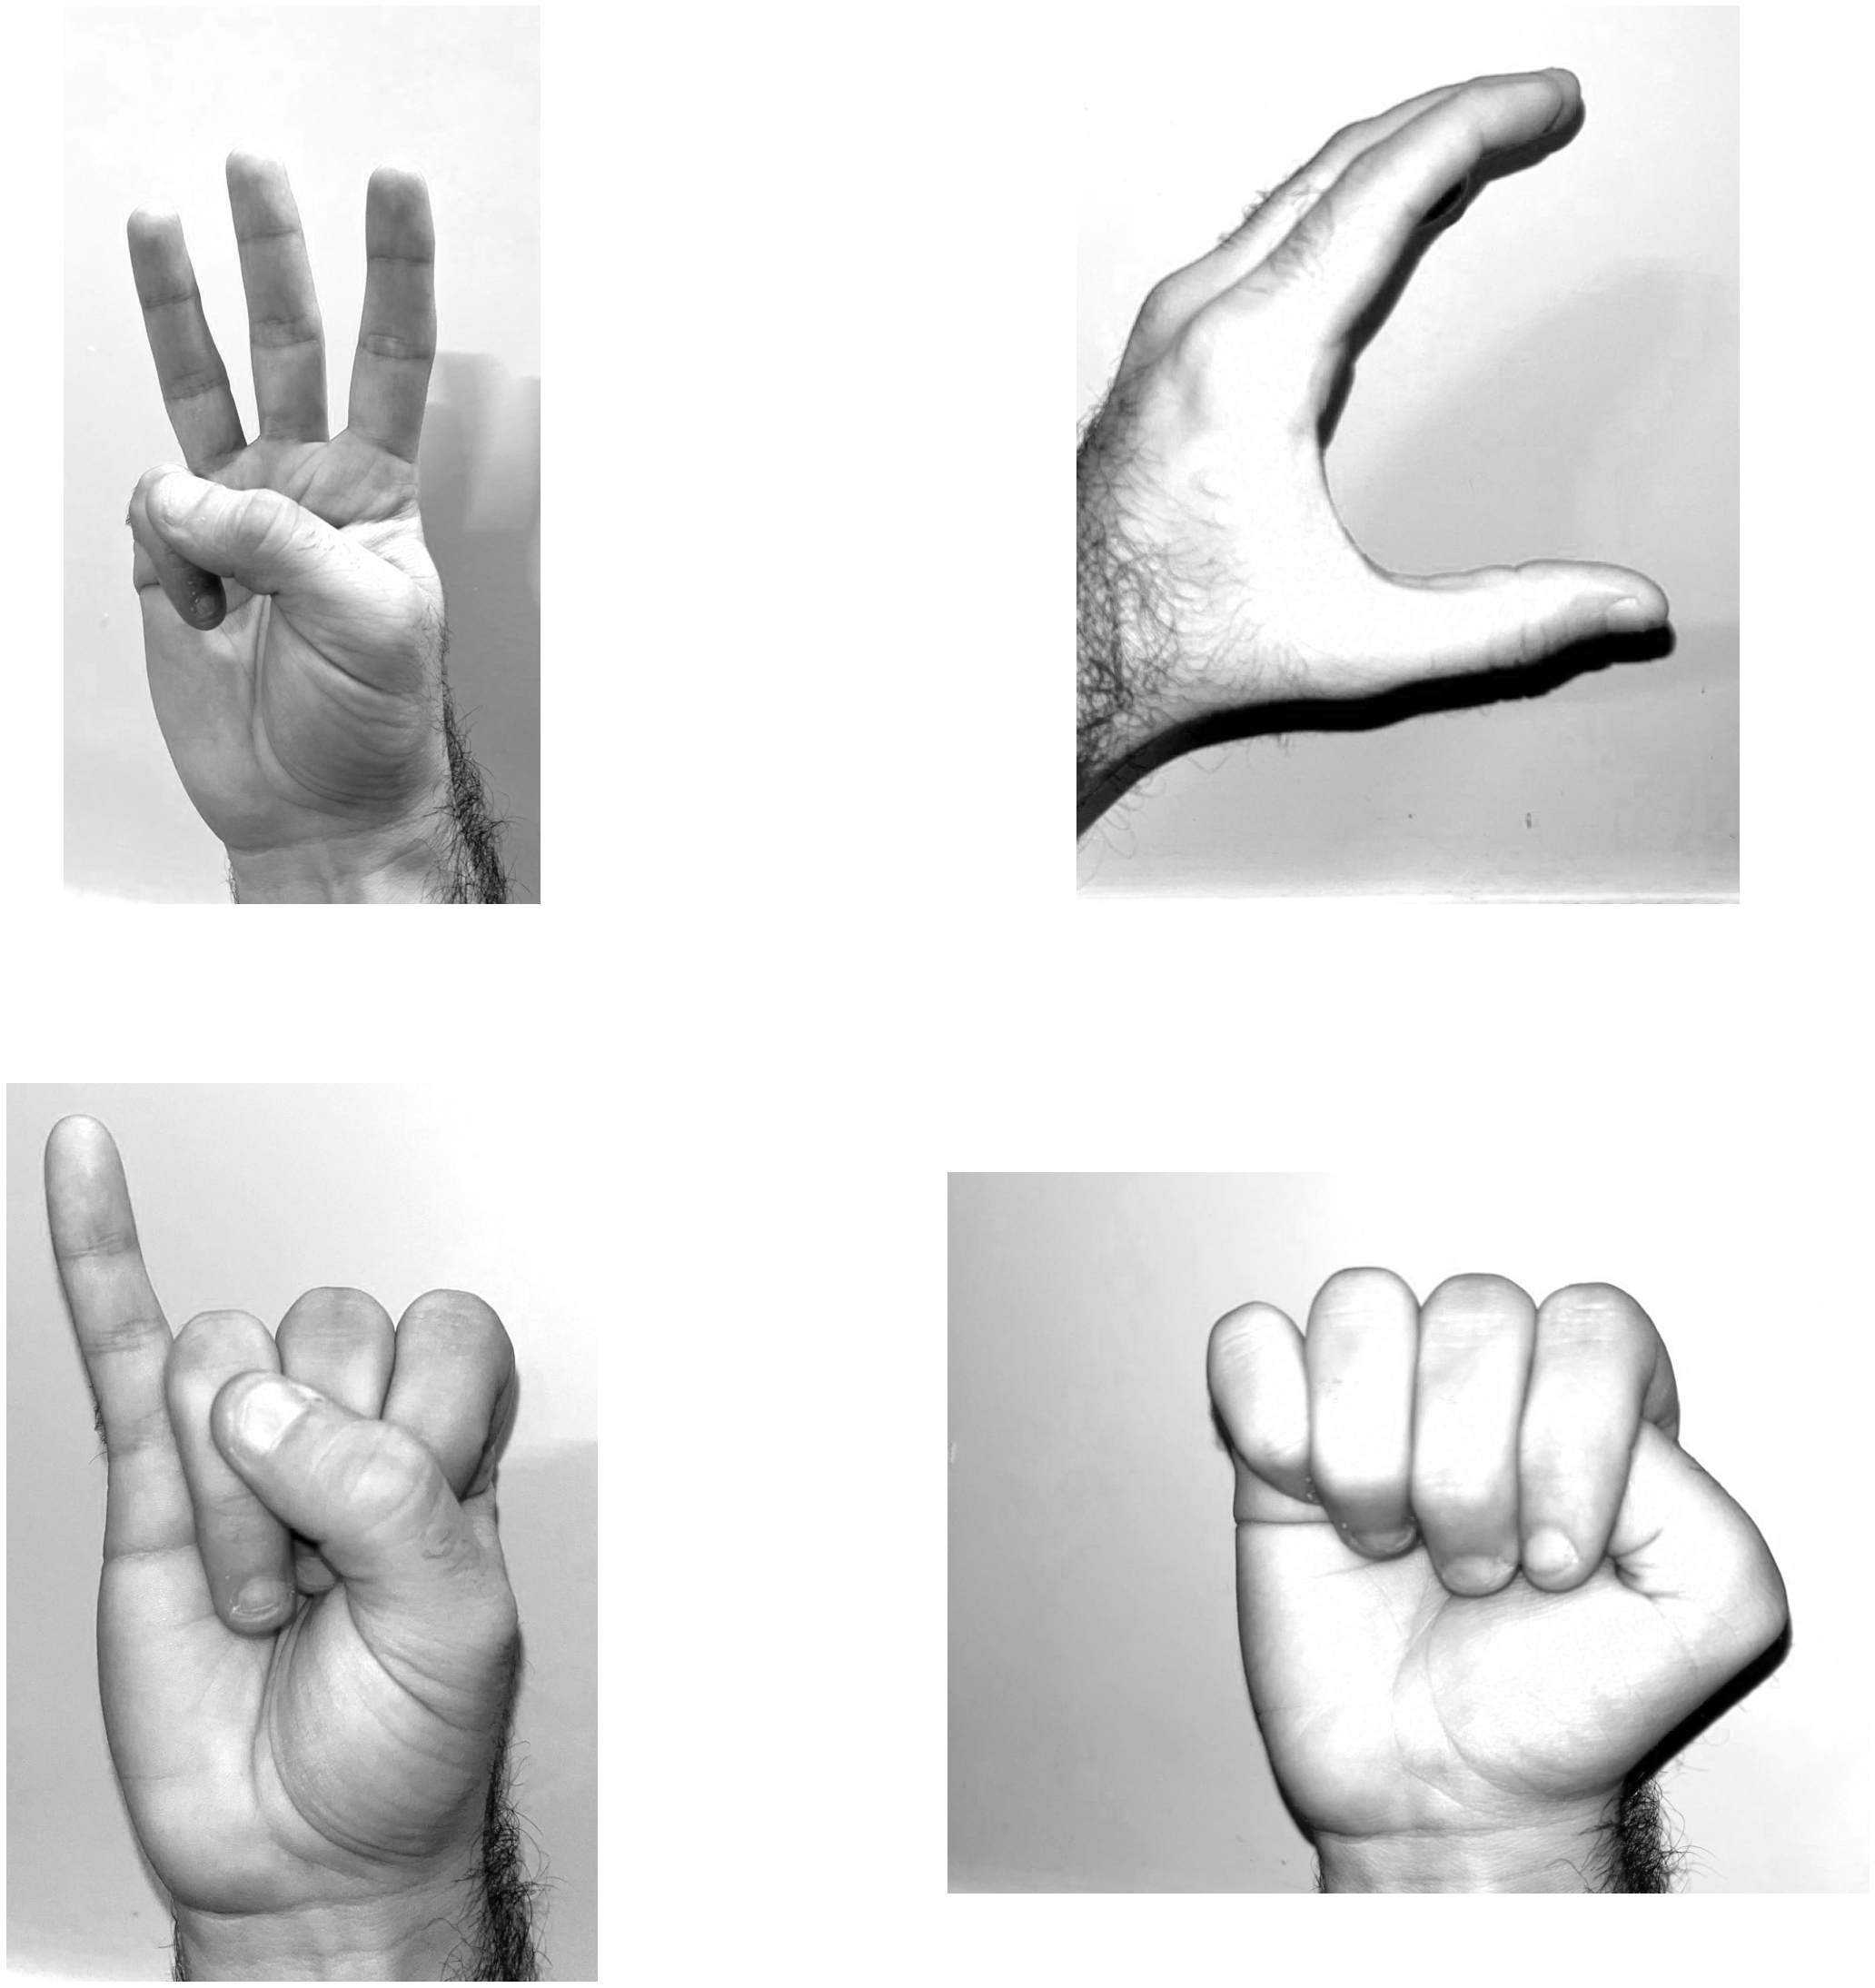

In [38]:
import torchvision.transforms as T
import torchvision.transforms as transforms

list_image = ['CamScanner 12-21-2022 20.24_1.jpg', 'CamScanner 12-21-2022 20.27_1.jpg',
              'CamScanner 12-21-2022 20.29_1.jpg','CamScanner 12-21-2022 20.30_1.jpg']

figure = plt.figure(figsize=(40, 40))

transform1 = transforms.Grayscale()
transform2 = T.Resize(size = (300,300))
j = 1

for i in list_image :
    image = read_image(i)
    figure.add_subplot(2, 2, j)
    plt.axis("off")
    plt.imshow(image[0,::], cmap="gray") 
    j +=1
plt.show()
 

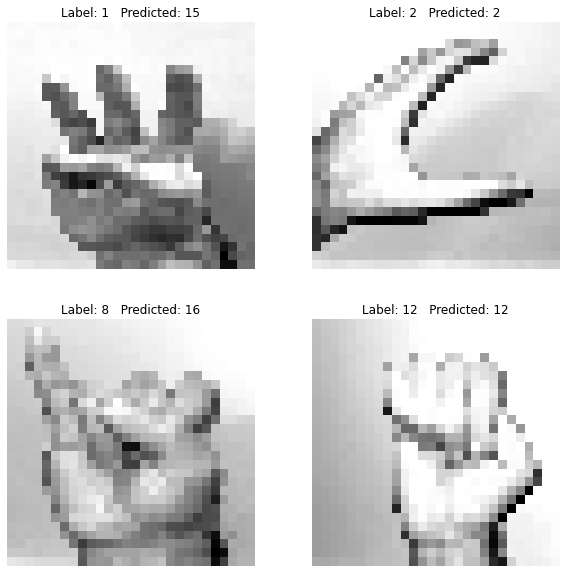

In [48]:
list_image = ['CamScanner 12-21-2022 20.24_1.jpg', 'CamScanner 12-21-2022 20.27_1.jpg',
              'CamScanner 12-21-2022 20.29_1.jpg','CamScanner 12-21-2022 20.30_1.jpg']

True_label = [1,2,8,12]

figure = plt.figure(figsize=(10, 10))

transform1 = transforms.Grayscale()
transform2 = T.Resize(size = (28,28))
j = 1
model_adam_drop.eval()
for i in list_image :
    image = read_image(i)
    img_resized = transform2(image)
    with torch.no_grad():
        img = (img_resized[0,:,:]/255.).view(1, -1)
        pred = model_adam_drop(img.to(torch.float32).to(device))
        
        figure.add_subplot(2, 2, j)
        plt.title(f"Label: {True_label[j-1]}   Predicted: {pred.argmax().item()}")
        plt.axis("off")
        plt.imshow(img_resized[0,:,:], cmap="gray")
        j += 1
        
plt.show()